## Handwritten Digit Recognition Using Neural Network

## Fetching MNIST data

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist =fetch_openml('mnist_784')

## Processing data

In [2]:
#setting training set to be the first 20000 examples and test set to be the next 5000 examples
X_train,Y_train,X_test,Y_test = mnist['data'][0:20000],mnist['target'][0:20000],mnist['data'][20000:25000],mnist['target'][20000:25000]
Y_train,Y_test = Y_train.reshape((20000,1)).astype(np.int8),Y_test.reshape((5000,1)).astype(np.int8)
shuffle_idx = np.random.permutation(20000)
#shuffling our training set to ensure that it is not sorted
X_train,Y_train = X_train[shuffle_idx],Y_train[shuffle_idx]    
X_train,X_test,Y_train,Y_test = X_train.T,X_test.T,Y_train.T,Y_test.T

Y_tr_oneVSall = np.zeros((10,Y_train.shape[1]))
labels = list(range(10))

for i in range(Y_train.shape[1]):
    for l in labels:
        if Y_train[0,i]==l:
            Y_tr_oneVSall[l,i]=1

## Initializing parameters 

In [3]:
labels = list(range(10))
n_x,n_h1,n_h2,n_y = X_train.shape[0],20,20,10
layer_dims = [n_x,n_h1,n_h2,n_y]

def initialize_parameters(layer_dims):
    parameters = {}
    for l in range(1,len(layer_dims)):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l],1))
    return parameters


## Setting up activation functions and their primes(here, sigmoid and relu)

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def relu(z):
    return np.maximum(0,z)

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def relu_prime(z):
    relu = np.zeros(z.shape)
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            if z[i][j]<0:
                relu[i][j] = 0
            elif z[i][j]>=0:
                relu[i][j] = 1
    return relu
    

## Forward propagation module

In [5]:
def forward_step(A_prev,W,b):
    Z = np.dot(W,A_prev) + b
    cache = (A_prev,W,b)
    return Z,cache 


def forward_activation(A_prev,W,b,activation):  
    if activation=="sigmoid":
        Z,linear_cache = forward_step(A_prev,W,b)
        A,activation_cache = sigmoid(Z),(Z)
    elif activation=="relu":
        Z,linear_cache = forward_step(A_prev,W,b)
        A,activation_cache = relu(Z),(Z)
    cache = (linear_cache,activation_cache)
    return A,cache
        
    
def forward_propagation(X,parameters):
    caches_list = []
    L = len(parameters)//2
    A = X
    for l in range(1,L+1):
        W = parameters['W'+str(l)]
        b = parameters['b'+str(l)]
        if l == L:
            A_prev = A
            activation = "sigmoid"
            AL,cache = forward_activation(A_prev,W,b,activation)
            caches_list.append(cache)
        else:
            A_prev = A
            activation = "relu"
            A,cache = forward_activation(A_prev,W,b,activation)
            caches_list.append(cache)
        
    return AL,caches_list
    

## Computing cost

In [6]:
def compute_cost(AL,Y_tr_oneVSall):
    m = AL.shape[1]
    cost = np.sum((-1/m)*np.sum(np.multiply(Y_tr_oneVSall,np.log(AL)) + np.multiply(1-Y_tr_oneVSall,np.log(1-AL))))
    return cost

## Backward propagation module

In [7]:
def backward_step(dZ,cache):
    m = dZ.shape[1]
    A_prev,W,b = cache
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev,dW,db


def backward_activation(dA,cache,activation):
    
    linear_cache,activation_cache = cache
    Z = activation_cache
    
    if activation == "sigmoid":
        dZ = np.multiply(dA,sigmoid_prime(Z))
        dA_prev,dW,db = backward_step(dZ,linear_cache)
    elif activation == "relu":
        dZ = np.multiply(dA,relu_prime(Z))
        dA_prev,dW,db = backward_step(dZ,linear_cache)
    return dA_prev,dW,db


def backward_propagation(AL,Y_tr_oneVSall,caches):
    L = len(caches)
    grads = {}
    dAL = -np.divide(Y_tr_oneVSall,AL) + np.divide(1-Y_tr_oneVSall,1-AL)
    cache = caches[-1]
    dA_prev,dW,db = backward_activation(dAL,cache,activation="sigmoid")
    grads['dA'+str(L-1)],grads['dW'+str(L)],grads['db'+str(L)] = dA_prev,dW,db
    for l in reversed(range(L-1)):
        cache = caches[l] 
        dA_prev,dW,db = backward_activation(grads['dA'+str(l+1)],cache,activation="relu") 
        grads['dA'+str(l)],grads['dW'+str(l+1)],grads['db'+str(l+1)] = dA_prev,dW,db
    return grads
    
    

## Updating parameters

In [8]:
def update_parameters(parameters,grads,learning_rate):

    L = len(parameters)//2
    for l in range(L):
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate*grads['dW'+str(l+1)] 
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate*grads['db'+str(l+1)]
    return parameters


## L-layer Neural network model

In [18]:

import matplotlib.pyplot as plt

def L_layer_model(X_train,Y_train,learning_rate=0.005,num_iterations=0):
    costs = []
    parameters = initialize_parameters(layer_dims)
    for iter in range(num_iterations):
        AL,caches_list = forward_propagation(X_train,parameters)
        cost = compute_cost(AL,Y_tr_oneVSall)
        grads = backward_propagation(AL,Y_tr_oneVSall,caches_list)
        parameters = update_parameters(parameters,grads,learning_rate)
        if iter%100==0:
            costs.append(cost)
            print("Iter",iter,": cost=",cost)
    print("minimized cost:",cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations(per hundred)')
    plt.title('Learning rate:'+str(learning_rate))
    plt.show()
    
    return parameters
        

## Training our model

Iter 0 : cost= 6.939589005676566
Iter 100 : cost= 1.807733104498957
Iter 200 : cost= 1.0239690786930464
Iter 300 : cost= 0.7149130137363441
Iter 400 : cost= 0.5887711297519455
Iter 500 : cost= 0.5145572315769947
Iter 600 : cost= 0.45638518181763543
Iter 700 : cost= 0.4106113131247697
Iter 800 : cost= 0.3761719387825063
Iter 900 : cost= 0.3487549443556903
Iter 1000 : cost= 0.3253333565446612
Iter 1100 : cost= 0.3062526180173792
Iter 1200 : cost= 0.2887552114778112
Iter 1300 : cost= 0.2739157705136935
Iter 1400 : cost= 0.26085933367679626
Iter 1500 : cost= 0.24871997522562367
Iter 1600 : cost= 0.24169337101181645
Iter 1700 : cost= 0.23953492155760184
Iter 1800 : cost= 0.22760082194214756
Iter 1900 : cost= 0.21613882376459806
minimized cost: 0.2069490552277647


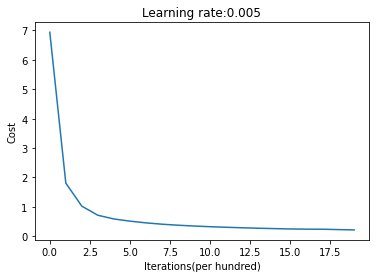

In [19]:
parameters = L_layer_model(X_train,Y_train,learning_rate=0.005,num_iterations=2000)

## Function to display an example

In [20]:
import matplotlib
import random

def disp_example(my_list,X,Y_pred):
    i = random.choice(my_list)
    sample_digit = X[:,i]
    digit_img = sample_digit.reshape(28,28)
    prediction = Y_pred[:,i]
    print("Our model predicts it to be",Y_pred[0,i])
    plt.imshow(digit_img,cmap=matplotlib.cm.binary,interpolation="nearest")
    

def right_example(Y_pred,Y,X):
    right = []
    for i in range(Y.shape[1]):
        if Y[0,i]==Y_pred[0,i]:
            right.append(i)
    print("An example of correct prediction:")
    disp_example(right,X,Y_pred)
    
def wrong_example(Y_pred,Y,X):
    wrong = []
    for i in range(Y.shape[1]):
        if Y[0,i]!=Y_pred[0,i]:
            wrong.append(i)
    print("An example of incorrect prediction:")
    disp_example(wrong,X,Y_pred)
        

    
    
    

## Accuracy on the training set

In [21]:
import matplotlib
def predict(X,Y,parameters):
    
    AL,caches_list = forward_propagation(X,parameters)
    Y_pred = np.argmax(AL,axis=0)
    Y_pred = Y_pred.reshape(Y.shape)
    right_pred = np.sum(Y_pred==Y)
    print("No. of values predicted correctly:",right_pred,"out of ",Y.shape[1])
    accuracy = (right_pred/Y.shape[1])*100
    return accuracy,Y_pred


print("Training Set")    
accuracy,Y_train_pred = predict(X_train,Y_train,parameters)
print("Accuracy:",accuracy,"%")
print("An example:")
#examples(Y_train_pred,Y_train,X_train)


Training Set
No. of values predicted correctly: 19441 out of  20000
Accuracy: 97.205 %
An example:


## Accuracy on the test set

In [23]:
print("Test Set")
accuracy,Y_test_pred = predict(X_test,Y_test,parameters)
print("Accuracy:",accuracy,"%")

Test Set
No. of values predicted correctly: 4699 out of  5000
Accuracy: 93.97999999999999 %


## An example of right prediction

An example of correct prediction:
Our model predicts it to be 9


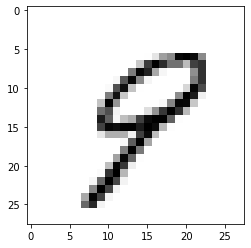

In [25]:
right_example(Y_test_pred,Y_test,X_test)

## An example of wrong prediction

An example of incorrect prediction:
Our model predicts it to be 5


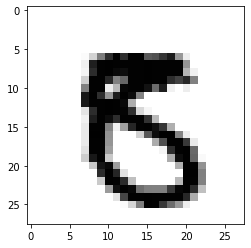

In [26]:
wrong_example(Y_test_pred,Y_test,X_test)